In [112]:
import numpy as np
import pandas as pd
import random
from collections import defaultdict
import gym
import gym_minigrid
import matplotlib.pyplot as plt
%matplotlib inline

In [113]:
def save_log(message, file_path):
    with open(file_path, "a") as f:
        f.write(message + "\n")

In [114]:
class QLearning:
    def __init__(self, actions, agent_indicator=10):
        self.actions = actions
        self.agent_indicator = agent_indicator
        self.alpha = 0.01
        self.gamma = 0.9
        self.epsilon = 0.2
        self.q_values = defaultdict(lambda: [0.0] * actions)

    def _convert_state(self, s):
        return np.where(s == self.agent_indicator)[0][0]

    def update(self, state, action, reward, next_state, next_action):
        state = self._convert_state(state)
        next_state = self._convert_state(next_state)

        q_value = self.q_values[state][action]

        ########################## Write Code ####################################
        next_q_value = max(self.q_values[next_state])
        td_error = reward + self.gamma * next_q_value - q_value
        self.q_values[state][action] = q_value + self.alpha * td_error

        ###########################################################################
    def act(self, state):
        #################### Write epsilion greedy code ###########################
        if np.random.rand() < self.epsilon:
            action = np.random.choice(self.actions)
        else:
            state = self._convert_state(state)
            q_values = self.q_values[state]
            action = int(np.argmax(q_values))
        ###########################################################################
        return action

In [115]:
from utils import gen_wrapped_env, show_video

In [116]:
env = gen_wrapped_env('MiniGrid-Empty-6x6-v0')
# env = gen_wrapped_env('MiniGrid-DoorKey-5x5-v0')

obs = env.reset()

agent_position = obs[0]

q_agent = QLearning(4, agent_position)

In [ ]:
q_rewards = []
q_values_over_time = []

for ep in range(300000):
    done = False
    obs = env.reset()
    q_action = q_agent.act(obs)
    q_ep_rewards = 0

    while not done:
        next_obs, reward, done, info = env.step(q_action)
        next_action = q_agent.act(next_obs)
        q_agent.update(obs, q_action, reward, next_obs, next_action)

        q_ep_rewards += reward
        obs = next_obs
        q_action = next_action

    q_rewards.append(q_ep_rewards)

    # Q-value 수렴 시각화를 위한 평균 Q 저장
    if (ep + 1) % 100 == 0:
        all_qs = [q for qs in q_agent.q_values.values() for q in qs]
        avg_q = np.mean(all_qs)
        q_values_over_time.append(avg_q)
        
        q_log_msg = f"Episode: {ep + 1}, Average Q-value: {avg_q}"
        print(q_log_msg)
        save_log(q_log_msg, "./logs/q_values_log_q.txt")

    if (ep + 1) % 20 == 0:
        log_msg = f"Episode: {ep + 1}, Q-Learning rewards: {q_ep_rewards}"
        print(log_msg)
        save_log(log_msg, "./logs/training_log_q.txt")

env.close()

Episode: 20, Q-Learning rewards: 0
Episode: 40, Q-Learning rewards: 0
Episode: 60, Q-Learning rewards: 0
Episode: 80, Q-Learning rewards: 0
Episode: 100, Average Q-value: 0.0
Episode: 100, Q-Learning rewards: 0
Episode: 120, Q-Learning rewards: 0
Episode: 140, Q-Learning rewards: 0
Episode: 160, Q-Learning rewards: 0
Episode: 180, Q-Learning rewards: 0
Episode: 200, Average Q-value: 1.966666666666667e-05
Episode: 200, Q-Learning rewards: 0
Episode: 220, Q-Learning rewards: 0
Episode: 240, Q-Learning rewards: 0
Episode: 260, Q-Learning rewards: 0
Episode: 280, Q-Learning rewards: 0
Episode: 300, Average Q-value: 1.84375e-05
Episode: 300, Q-Learning rewards: 0
Episode: 320, Q-Learning rewards: 0
Episode: 340, Q-Learning rewards: 0
Episode: 360, Q-Learning rewards: 0
Episode: 380, Q-Learning rewards: 0
Episode: 400, Average Q-value: 1.84375e-05
Episode: 400, Q-Learning rewards: 0
Episode: 420, Q-Learning rewards: 0
Episode: 440, Q-Learning rewards: 0
Episode: 460, Q-Learning rewards: 0
Ep

In [ ]:
{s:np.round(q, 5).tolist() for s, q in q_agent.q_values.items()}

In [ ]:
show_video()

In [ ]:
pd.Series(q_rewards).to_csv('./logs/rewards_qlearning.csv')

q_table_dict = {str(s): [round(v, 5) for v in q] for s, q in q_agent.q_values.items()}
with open('./logs/q_table_qlearning.json', 'w') as f:
    json.dump(q_table_dict, f, indent=2)
    
policy = {str(s): int(np.argmax(q)) for s, q in q_agent.q_values.items()}
with open('./logs/policy_qlearning.json', 'w') as f:
    json.dump(policy, f, indent=2)

In [ ]:
q_logs = pd.read_csv('./logs/rewards_qlearning.csv', index_col=False).iloc[:, 1]

In [ ]:
plt.figure(figsize=(16, 8))
plt.plot(q_logs.cumsum() / (pd.Series(np.arange(q_logs.shape[0]))+1), label="QLearning")
plt.legend()

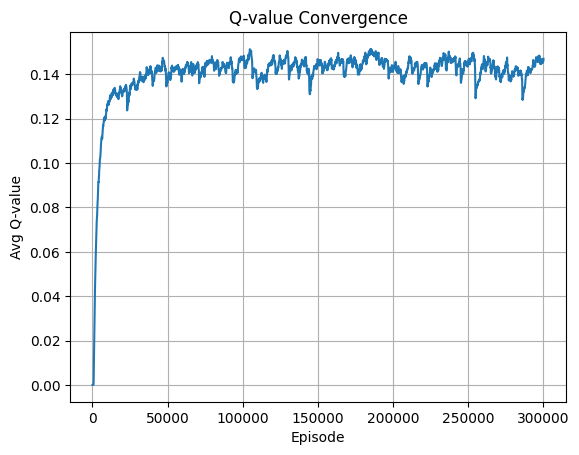

In [138]:
episodes = []
avg_q_values = []

# 로그 파일 불러오기
with open("./logs/q_values_log_q.txt", "r") as f:
    for line in f:
        if "Episode:" in line and "Average Q-value:" in line:
            parts = line.strip().split(", ")
            ep = int(parts[0].split(": ")[1])
            q_val = float(parts[1].split(": ")[1])
            episodes.append(ep)
            avg_q_values.append(q_val)

# 그래프 그리기
plt.figure()
plt.plot(episodes, avg_q_values)
plt.title("Q-value Convergence")
plt.xlabel("Episode")
plt.ylabel("Avg Q-value")
plt.grid()
plt.savefig("./logs/plots/q_value_convergence.png")
plt.show()

In [ ]:
class SARSA:
    def __init__(self, actions, agent_indicator=10):
        self.actions = actions
        self.agent_indicator = agent_indicator

        self.alpha = 0.01
        self.gamma = 0.9
        self.epsilon = 0.2
        self.q_values = defaultdict(lambda: [0.0] * actions)

    def _convert_state(self, s):
        return np.where(s == self.agent_indicator)[0][0]

    def update(self, state, action, reward, next_state, next_action):
        state = self._convert_state(state)
        next_state = self._convert_state(next_state)

        q_value = self.q_values[state][action]

        ########################## Write Code ####################################
        next_q_value = self.q_values[next_state][next_action]
        td_error = reward + self.gamma * next_q_value - q_value
        self.q_values[state][action] = q_value + self.alpha * td_error

        ###########################################################################
    def act(self, state):
        #################### Write epsilion greedy code ###########################
        if np.random.rand() < self.epsilon:
            action = np.random.choice(self.actions)
        else:
            state = self._convert_state(state)
            q_values = self.q_values[state]
            action = int(np.argmax(q_values))
        ###########################################################################
        return action

In [ ]:
env = gen_wrapped_env('MiniGrid-Empty-6x6-v0')
# env = gen_wrapped_env('MiniGrid-DoorKey-5x5-v0')

obs = env.reset()

agent_position = obs[0]

sarsa_agent = SARSA(4, agent_position)

In [ ]:
sarsa_rewards = []
sarsa_q_values_over_time = []

for ep in range(300000):
    done = False
    obs = env.reset()
    sarsa_action = sarsa_agent.act(obs)
    sarsa_ep_rewards = 0

    while not done:
        next_obs, reward, done, info = env.step(sarsa_action)
        next_action = sarsa_agent.act(next_obs)
        sarsa_agent.update(obs, sarsa_action, reward, next_obs, next_action)

        sarsa_ep_rewards += reward
        obs = next_obs
        sarsa_action = next_action

    sarsa_rewards.append(sarsa_ep_rewards)

    if (ep + 1) % 100 == 0:
        all_qs = [q for qs in sarsa_agent.q_values.values() for q in qs]
        avg_q = np.mean(all_qs)
        sarsa_q_values_over_time.append(avg_q)
        
        q_log_msg = f"Episode: {ep + 1}, Average Q-value: {avg_q}"
        print(q_log_msg)
        save_log(q_log_msg, "./logs/q_values_log_sarsa.txt")

    if (ep + 1) % 20 == 0:
        log_msg = f"Episode: {ep + 1}, SARSA rewards: {sarsa_ep_rewards}"
        print(log_msg)
        save_log(log_msg, "./logs/training_log_sarsa.txt")

env.close()

In [ ]:
{s:np.round(q, 5).tolist() for s, q in sarsa_agent.q_values.items()}

In [ ]:
print("Learned Q-table states:", len(q_agent.q_values))
print("Some state keys:", list(q_agent.q_values.keys())[:10])

In [ ]:
show_video()

In [ ]:
pd.Series(sarsa_rewards).to_csv('./logs/rewards_sarsa.csv')

q_table_dict = {str(s): [round(v, 5) for v in q] for s, q in sarsa_agent.q_values.items()}
with open('./logs/q_table_sarsa.json', 'w') as f:
    json.dump(q_table_dict, f, indent=2)
    
policy = {str(s): int(np.argmax(q)) for s, q in sarsa_agent.q_values.items()}
with open('./logs/policy_sarsa.json', 'w') as f:
    json.dump(policy, f, indent=2)

In [ ]:
sarsa_logs = pd.read_csv('./logs/rewards_sarsa.csv', index_col=False).iloc[:, 1]

In [ ]:
plt.figure(figsize=(16, 8))
plt.plot(q_logs.cumsum() / (pd.Series(np.arange(q_logs.shape[0]))+1), label="QLearning")
plt.plot(sarsa_logs.cumsum() / (pd.Series(np.arange(sarsa_logs.shape[0]))+1), label="SARSA")
plt.legend()

In [ ]:
sarsa_episodes = []
sarsa_avg_q_values = []

# SARSA 로그 파일 불러오기
with open("./logs/q_values_log_sarsa.txt", "r") as f:
    for line in f:
        if "Episode:" in line and "Average Q-value:" in line:
            parts = line.strip().split(", ")
            ep = int(parts[0].split(": ")[1])
            q_val = float(parts[1].split(": ")[1])
            sarsa_episodes.append(ep)
            sarsa_avg_q_values.append(q_val)

# 그래프 그리기
plt.figure()
plt.plot(sarsa_episodes, sarsa_avg_q_values)
plt.title("SARSA Q-value Convergence")
plt.xlabel("Episode")
plt.ylabel("Avg Q-value")
plt.grid()
plt.savefig("./logs/plots/sarsa_q_value_convergence.png")
plt.show()


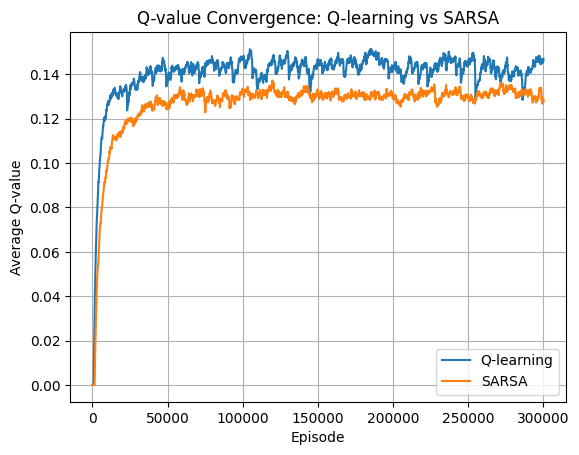

In [139]:
episodes = []
avg_q_values = []

# Q-learning 로그 파일 불러오기
with open("./logs/q_values_log_q.txt", "r") as f:
    for line in f:
        if "Episode:" in line and "Average Q-value:" in line:
            parts = line.strip().split(", ")
            ep = int(parts[0].split(": ")[1])
            q_val = float(parts[1].split(": ")[1])
            episodes.append(ep)
            avg_q_values.append(q_val)

sarsa_episodes = []
sarsa_avg_q_values = []

# SARSA 로그 파일 불러오기
with open("./logs/q_values_log_sarsa.txt", "r") as f:
    for line in f:
        if "Episode:" in line and "Average Q-value:" in line:
            parts = line.strip().split(", ")
            ep = int(parts[0].split(": ")[1])
            q_val = float(parts[1].split(": ")[1])
            sarsa_episodes.append(ep)
            sarsa_avg_q_values.append(q_val)

# 하나의 그래프에 둘 다 그리기
plt.figure()
plt.plot(episodes, avg_q_values, label="Q-learning")
plt.plot(sarsa_episodes, sarsa_avg_q_values, label="SARSA")
plt.title("Q-value Convergence: Q-learning vs SARSA")
plt.xlabel("Episode")
plt.ylabel("Average Q-value")
plt.legend()
plt.grid()
plt.savefig("./logs/plots/q_vs_sarsa_q_value_convergence.png")
plt.show()

In [ ]:
def compare_policy_heatmaps(q_agent, sarsa_agent, grid_size=(6, 6)):
    fig, axes = plt.subplots(1, 2, figsize=(12, 5))

    for ax, agent, title in zip(axes,
                                 [q_agent, sarsa_agent],
                                 ["Q-Learning Policy", "SARSA Policy"]):
        policy = np.full(grid_size, -1, dtype=int)

        for state, q_values in agent.q_values.items():
            # state는 평탄화된 벡터의 인덱스 (agent가 있는 위치의 vector index)
            cell_index = state // 3  # 셀 단위로 묶어서 몇 번째 셀인지 추출
            x = cell_index % grid_size[0]
            y = cell_index // grid_size[0]
            if y < grid_size[1]:
                policy[y, x] = int(np.argmax(q_values))

        im = ax.imshow(policy, cmap='viridis', interpolation='nearest')
        ax.set_title(title)
        ax.set_xlabel("X position")
        ax.set_ylabel("Y position")
        ax.set_xticks(np.arange(grid_size[0]))
        ax.set_yticks(np.arange(grid_size[1]))
        fig.colorbar(im, ax=ax, fraction=0.046, pad=0.04)

    plt.tight_layout()
    plt.show()

compare_policy_heatmaps(q_agent, sarsa_agent, grid_size=(4, 4))